In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier 

## Last pre-processing

Rename the columns as well as change positive tweets from target = 4 to target = 1

In [32]:
df = pd.read_csv("../tweets-cleaned.csv", encoding='ISO-8859-1')
df = df.iloc[:, [0, 2]] # Don't want the data from before processing
df

,target,clean
0,0,URL aww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see
...,...,...
1599995,4,woke school best feeling ever
1599996,4,URL cool hear old walt interview URL
1599997,4,ready mojo makeover URL detail
1599998,4,happy th birthday boo all time tupac amaru shakur


In [33]:
df['target'].replace(4, 1, inplace=True) # Replace all the 4s with 1s
df.rename(columns={'target': 'sentiment', 'text':'tweet'}, inplace=True) # Rename the columns
df

,sentiment,clean
0,0,URL aww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see
...,...,...
1599995,1,woke school best feeling ever
1599996,1,URL cool hear old walt interview URL
1599997,1,ready mojo makeover URL detail
1599998,1,happy th birthday boo all time tupac amaru shakur


In [40]:
df.dtypes

sentiment     int64
clean        object
dtype: object

In [47]:
text, sentiment = list(df['clean']), list(df['sentiment']) # Turn these both into lists

text = [str(item) for item in text]
positive_text = text[800000:] # Dataset arranged in a way such that the first half is negative and second half is positive
negative_text = text[:800000]

## Word cloud for positive and negative text

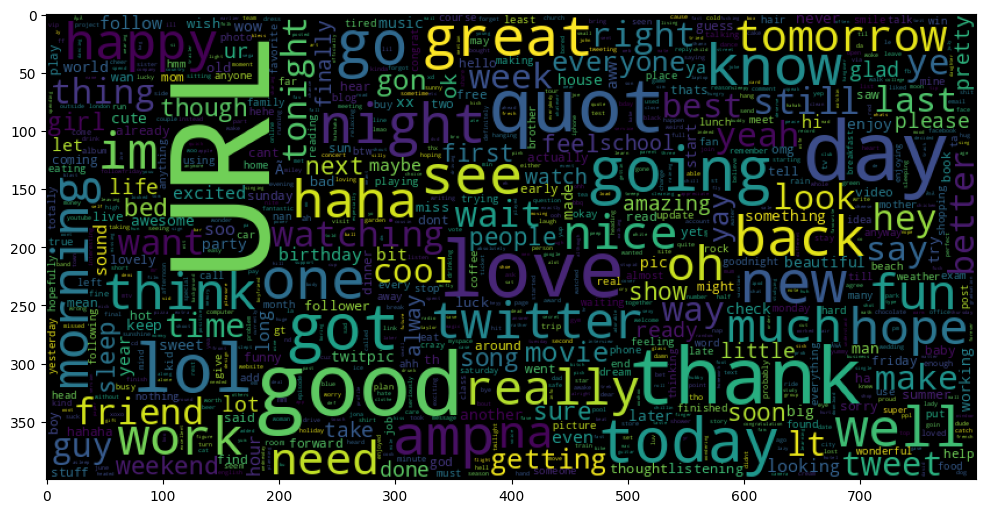

In [48]:
# Positive text
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(positive_text))
plt.imshow(wc)

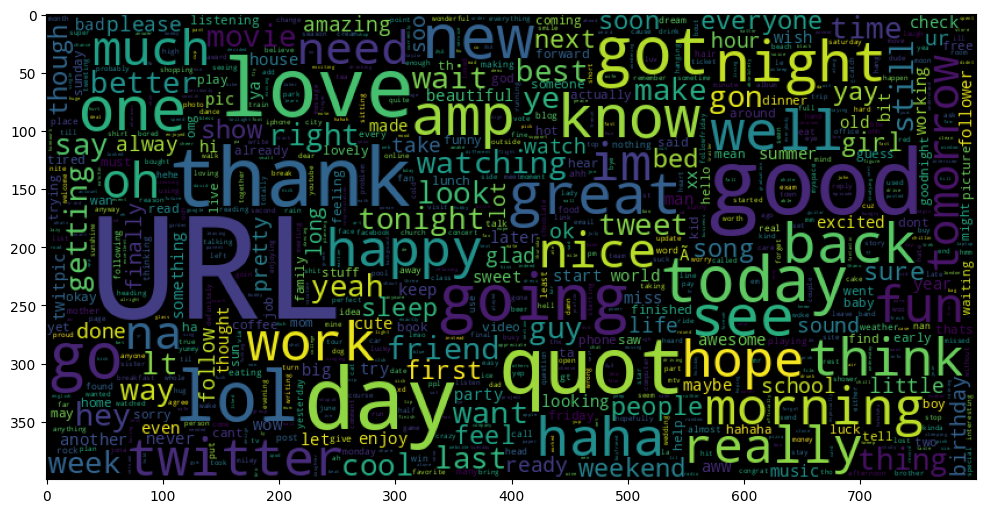

In [46]:
# Negative text
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(positive_text))
plt.imshow(wc)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment,
                                                    test_size = 0.2, random_state = 0) # Get the training split, with 20% of the example being used for validation

## TF-IDF Vectoriser

Summarized explanation: TF-IDF indicates what the importance of the word is in order to understand the document or dataset. Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

ngram_range is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]. We will personally be using bigrams as well as single words

max_features specifies the number of features to consider. [Ordered by feature frequency across the corpus]. Each word basically counts as a feature and each bigram of two words counts as ANOTHER feature, so we don't want it to get too excessive

In [55]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=700000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  700000


## Transform the dataset
Transform X_train and X_test with .transform into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train/test the models

In [56]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## Train and evaluate

In [63]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.80      0.77      0.79    159815
           1       0.78      0.81      0.80    160185

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



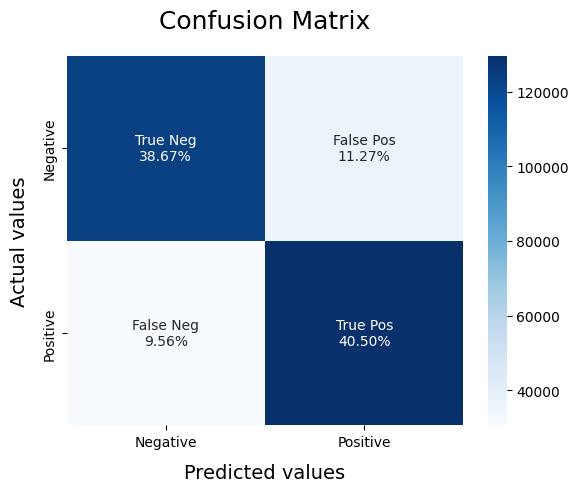

In [65]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159815
           1       0.76      0.80      0.78    160185

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



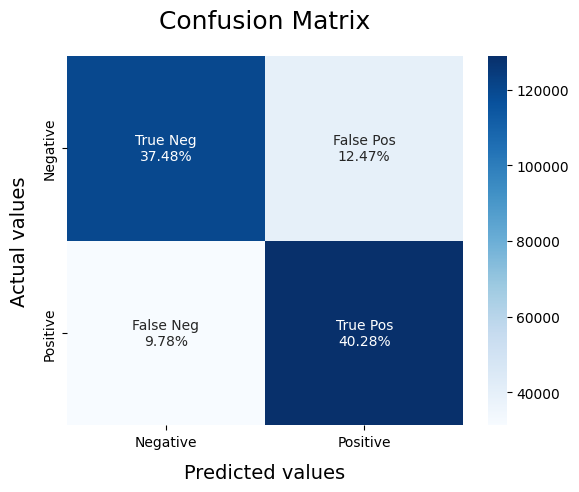

In [67]:
Bern = BernoulliNB(alpha = 2)
Bern.fit(X_train, y_train)
model_Evaluate(Bern)

In [ ]:
Grad = GradientBoostingClassifier()
Grad.fit(X_train, y_train)
model_Evaluate(Grad)